# Cotton Candy Quality Classification Model

This notebook creates classification models to predict optimal `start_temp` and `cook_temp` values based on environmental variables to achieve the best cotton candy quality.

## Objective
- Train classification models using environmental input variables
- Predict quality categories (0-3) from `my_score` values
- Find optimal temperature settings for high-quality cotton candy production
- Compare multiple simple models with Random Forest

## Input Features (Environmental Variables)
- `baseline_env_EnvH`: Baseline environmental humidity
- `baseline_env_EnvT`: Baseline environmental temperature
- `before_turn_on_env_InH`: Internal humidity before turn on
- `before_turn_on_env_InT`: Internal temperature before turn on
- `before_turn_on_env_IrO`: Head temperature before turn on

## Target Optimization
Find optimal `start_temp` and `cook_temp` values that maximize cotton candy quality scores.

## 1. Data Loading and Initial Exploration

In [30]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import joblib

# Set display options
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [31]:
# Load the dataset
data_path = '/Users/nicolas/Desktop/Cotton-Candy-Digital-Twin/DT-0509/Complete_cc_dataset.csv'
df = pd.read_csv(data_path, sep=';', header=1)  # Skip first row and use second as header

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
df.head()

Dataset shape: (185, 52)
Columns: ['iteration', 'batch_number', 'stick_number', 'index_log', 'stick_weight', 'sugar_amount', 'iteration_since_maintenance', 'wait_time', 'cook_time', 'cooldown_time', 'start_temp', 'cook_temp', 'cooled_temp', 'duration_till_handover', 'duration_total', 'show_start_time', 'show_end_time', 'duration_cc_flow', 'diff_flow', 'diff_flow_stop', 'baseline_env_EnvH', 'baseline_env_EnvT', 'before_turn_on_env_InH', 'before_turn_on_env_InT', 'before_turn_on_env_IrO', 'before_turn_on_env_IrA', 'after_flow_start_env_InH', 'after_flow_start_env_InT', 'after_flow_start_env_IrO', 'after_flow_start_env_IrA', 'after_flow_end_env_InH', 'after_flow_end_env_InT', 'after_flow_end_env_IrO', 'after_flow_end_env_IrA', 'before_cooldown_env_InH', 'before_cooldown_env_InT', 'before_cooldown_env_IrO', 'before_cooldown_env_IrA', 'after_cooldown_env_InH', 'after_cooldown_env_InT', 'after_cooldown_env_IrO', 'after_cooldown_env_IrA', 'touch_pos1', 'touch_pos2', 'touch_pos3', 'max_pos1', 

,iteration,batch_number,stick_number,index_log,stick_weight,sugar_amount,iteration_since_maintenance,wait_time,cook_time,cooldown_time,start_temp,cook_temp,cooled_temp,duration_till_handover,duration_total,show_start_time,show_end_time,duration_cc_flow,diff_flow,diff_flow_stop,baseline_env_EnvH,baseline_env_EnvT,before_turn_on_env_InH,before_turn_on_env_InT,before_turn_on_env_IrO,before_turn_on_env_IrA,after_flow_start_env_InH,after_flow_start_env_InT,after_flow_start_env_IrO,after_flow_start_env_IrA,after_flow_end_env_InH,after_flow_end_env_InT,after_flow_end_env_IrO,after_flow_end_env_IrA,before_cooldown_env_InH,before_cooldown_env_InT,before_cooldown_env_IrO,before_cooldown_env_IrA,after_cooldown_env_InH,after_cooldown_env_InT,after_cooldown_env_IrO,after_cooldown_env_IrA,touch_pos1,touch_pos2,touch_pos3,max_pos1,max_pos2,max_pos3,cc_weight,quality_score,my_score,Unnamed: 51
0,0.0,0.0,0.0,61169.0,1.8,1.0,52.0,102.0,105.0,60.0,25.49,31.75,62.03,286.56,524.56,47:32,49:11,98.90,NaN,NaN,63.73,24.59,39.26,37.90,25.67,25.99,50.03,32.05,60.73,27.07,39.62,38.11,87.29,30.07,NaN,NaN,NaN,NaN,37.22,39.28,59.73,31.33,2.0,2.0,3.0,30.80,0.00,21.91,10.02,NaN,60,NaN
1,1.0,0.0,1.0,61177.0,1.8,1.0,53.0,102.0,105.0,60.0,58.89,60.63,64.65,289.77,478.86,54:58,55:51,53.71,NaN,NaN,62.78,24.65,37.33,39.20,59.01,31.41,39.26,37.90,65.47,31.07,35.94,40.66,77.81,31.51,33.09,42.70,83.27,31.45,34.42,41.36,62.35,31.09,4.0,1.0,3.0,23.54,7.08,2.46,8.48,NaN,15,NaN
2,2.0,0.0,2.0,61184.0,1.8,1.0,54.0,102.0,105.0,60.0,61.85,62.47,61.63,287.95,484.25,02:51,03:42,51.01,NaN,NaN,62.49,24.72,34.53,41.30,61.77,31.05,36.72,39.58,66.27,31.09,33.25,42.66,79.31,31.69,NaN,NaN,NaN,NaN,34.14,41.51,59.33,31.37,1.0,4.0,3.0,27.52,0.00,22.54,8.19,NaN,10,NaN
3,3.0,0.0,3.0,61191.0,1.8,1.0,55.0,102.0,105.0,60.0,58.63,60.55,76.97,292.07,438.94,11:04,12:07,62.88,NaN,NaN,62.44,24.72,34.24,41.45,58.45,31.29,36.89,39.47,66.15,31.15,31.62,44.17,80.85,32.23,32.01,43.53,77.57,31.91,32.04,43.49,74.67,31.87,5.0,4.0,6.0,32.47,30.77,19.16,8.20,NaN,8,NaN
4,4.0,1.0,0.0,61233.0,1.8,1.0,0.0,102.0,105.0,60.0,25.41,31.05,60.03,286.41,466.78,08:33,09:34,60.96,NaN,NaN,60.44,23.63,62.36,24.53,25.47,25.29,49.03,30.76,58.79,26.11,41.48,35.09,74.01,28.25,35.35,39.15,78.99,30.21,36.02,38.41,57.73,29.85,1.0,3.0,1.0,34.85,2.58,13.55,9.99,NaN,80,NaN


In [32]:
# Examine data types and missing values
print("Data info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False).head(10))
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Check unique values in key columns
print(f"\nUnique values in 'my_score': {sorted(df['my_score'].dropna().unique())}")
print(f"Missing 'my_score' values: {df['my_score'].isnull().sum()}")
print(f"Missing 'iteration' values: {df['iteration'].isnull().sum()}")

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   iteration                    172 non-null    float64
 1   batch_number                 180 non-null    float64
 2   stick_number                 180 non-null    float64
 3   index_log                    180 non-null    float64
 4   stick_weight                 180 non-null    float64
 5   sugar_amount                 180 non-null    float64
 6   iteration_since_maintenance  180 non-null    float64
 7   wait_time                    180 non-null    float64
 8   cook_time                    180 non-null    float64
 9   cooldown_time                177 non-null    float64
 10  start_temp                   185 non-null    float64
 11  cook_temp                    185 non-null    float64
 12  cooled_temp                  180 non-null    float64
 13  duration_

## 2. Data Cleaning and Preprocessing

In [33]:
# Remove rows with missing my_score or iteration values
print(f"Original dataset shape: {df.shape}")

# Remove rows where my_score or iteration is missing
df_clean = df.dropna(subset=['my_score', 'iteration']).copy()
print(f"After removing missing my_score/iteration: {df_clean.shape}")

# Convert my_score to numeric and handle any non-numeric entries
df_clean['my_score'] = pd.to_numeric(df_clean['my_score'], errors='coerce')
df_clean = df_clean.dropna(subset=['my_score'])
print(f"After converting my_score to numeric: {df_clean.shape}")

# Focus on last 60 rows for more complete data
df_last_60 = df_clean.tail(60).copy()
print(f"Last 60 rows shape: {df_last_60.shape}")

# Check data completeness in last 60 rows
print(f"\nMissing values in last 60 rows:")
print(df_last_60.isnull().sum().sort_values(ascending=False).head(10))

Original dataset shape: (185, 52)
After removing missing my_score/iteration: (172, 52)
After converting my_score to numeric: (150, 52)
Last 60 rows shape: (60, 52)

Missing values in last 60 rows:
Unnamed: 51                60
quality_score              19
diff_flow_stop             10
diff_flow                  10
cc_weight                   8
before_cooldown_env_InH     8
before_cooldown_env_InT     8
before_cooldown_env_IrO     8
before_cooldown_env_IrA     8
cooldown_time               3
dtype: int64


In [34]:
# Handle temperature sensor anomalies (IrO columns should be 0-120°C)
# Identify all IrO columns (infrared temperature sensors)
iro_columns = [col for col in df_last_60.columns if col.endswith('IrO')]
print(f"IrO temperature columns: {iro_columns}")

# Also include start_temp and cook_temp as they are the same sensor type
temp_columns = iro_columns + ['start_temp', 'cook_temp']
print(f"All temperature columns: {temp_columns}")

# Check temperature ranges before cleaning
print("\nTemperature ranges before cleaning:")
for col in temp_columns:
    if col in df_last_60.columns:
        values = pd.to_numeric(df_last_60[col], errors='coerce')
        print(f"{col}: {values.min():.2f} to {values.max():.2f}")

# Clean temperature values (should be between 0-120°C)
df_processed = df_last_60.copy()
for col in temp_columns:
    if col in df_processed.columns:
        # Convert to numeric
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        # Mark values outside 0-120 range as invalid
        mask = (df_processed[col] < 0) | (df_processed[col] > 120)
        if mask.sum() > 0:
            print(f"Found {mask.sum()} anomalous values in {col}")
            df_processed.loc[mask, col] = np.nan

print(f"\nFinal processed dataset shape: {df_processed.shape}")

IrO temperature columns: ['before_turn_on_env_IrO', 'after_flow_start_env_IrO', 'after_flow_end_env_IrO', 'before_cooldown_env_IrO', 'after_cooldown_env_IrO']
All temperature columns: ['before_turn_on_env_IrO', 'after_flow_start_env_IrO', 'after_flow_end_env_IrO', 'before_cooldown_env_IrO', 'after_cooldown_env_IrO', 'start_temp', 'cook_temp']

Temperature ranges before cleaning:
before_turn_on_env_IrO: 22.19 to 70.41
after_flow_start_env_IrO: 54.99 to 75.63
after_flow_end_env_IrO: 66.99 to 94.05
before_cooldown_env_IrO: 65.43 to 94.81
after_cooldown_env_IrO: 49.05 to 73.27
start_temp: 31.33 to 68.97
cook_temp: 33.49 to 71.61

Final processed dataset shape: (60, 52)


In [35]:
# Create categorical target variable from my_score
# 0: <25 (very bad), 1: 25-49 (bad), 2: 50-70 (good), 3: >70 (very good)
def create_quality_categories(score):
    if score < 25:
        return 0
    elif 25 <= score < 50:
        return 1
    elif 50 <= score <= 70:
        return 2
    else:
        return 3

df_processed['quality_category'] = df_processed['my_score'].apply(create_quality_categories)

# Display category distribution
print("Quality category distribution:")
category_counts = df_processed['quality_category'].value_counts().sort_index()
print(category_counts)
print(f"\nCategory percentages:")
print((category_counts / len(df_processed) * 100).round(1))

# Display score ranges for each category
print("\nScore ranges by category:")
for cat in sorted(df_processed['quality_category'].unique()):
    scores = df_processed[df_processed['quality_category'] == cat]['my_score']
    print(f"Category {cat}: {scores.min()}-{scores.max()} (n={len(scores)})")

Quality category distribution:
quality_category
0     3
1    27
2    29
3     1
Name: count, dtype: int64

Category percentages:
quality_category
0     5.0
1    45.0
2    48.3
3     1.7
Name: count, dtype: float64

Score ranges by category:
Category 0: 0.0-20.0 (n=3)
Category 1: 25.0-48.0 (n=27)
Category 2: 50.0-70.0 (n=29)
Category 3: 75.0-75.0 (n=1)


BINARY CLASSIFICATION APPROACH
Binary Classification (Threshold = 45):
Not Good (0, <45): 20 samples (33.3%)
Good (1, ≥45): 40 samples (66.7%)

Score ranges by binary category:
Not Good (0): 0.0-43.0 (n=20)
Good (1): 45.0-75.0 (n=40)

Using BINARY CLASSIFICATION for model training
Target variable distribution: {0: 20, 1: 40}


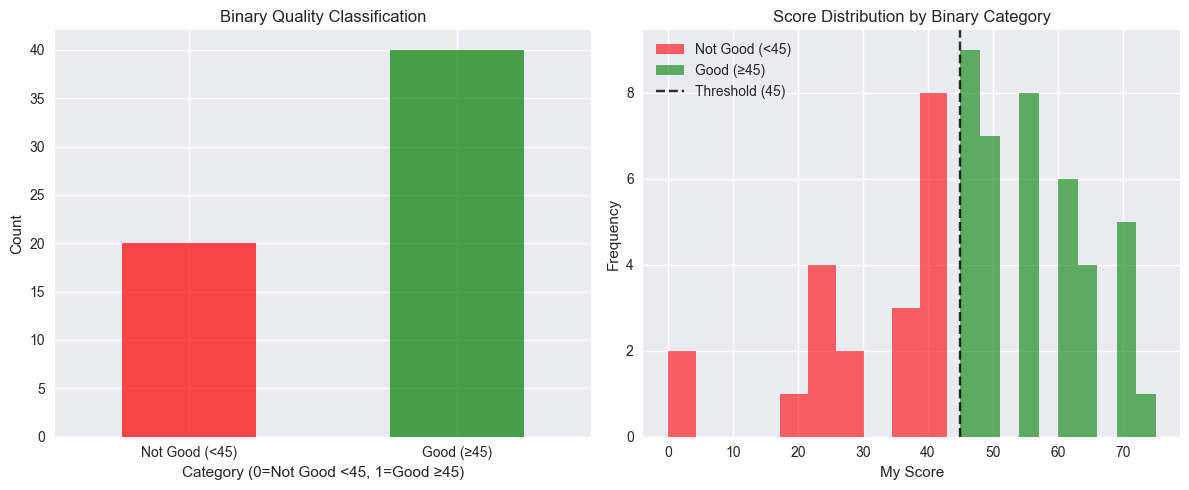


This binary approach will be used for the rest of the analysis!
Goal: Predict conditions that lead to Good cotton candy (score ≥45)


In [36]:
# Updated Binary Classification: Good ≥45, Not Good <45

print("BINARY CLASSIFICATION APPROACH")
print("=" * 50)

# Binary classification with threshold at 45
def create_binary_categories(score):
    return 1 if score >= 45 else 0  # 1 = Good (≥45), 0 = Not Good (<45)

df_processed['binary_category'] = df_processed['my_score'].apply(create_binary_categories)
binary_counts = df_processed['binary_category'].value_counts().sort_index()

print("Binary Classification (Threshold = 45):")
print(f"Not Good (0, <45): {binary_counts[0]} samples ({binary_counts[0]/len(df_processed)*100:.1f}%)")
print(f"Good (1, ≥45): {binary_counts[1]} samples ({binary_counts[1]/len(df_processed)*100:.1f}%)")

# Show score distribution for each binary category
print(f"\nScore ranges by binary category:")
for cat in sorted(df_processed['binary_category'].unique()):
    scores = df_processed[df_processed['binary_category'] == cat]['my_score']
    cat_name = "Not Good" if cat == 0 else "Good"
    print(f"{cat_name} ({cat}): {scores.min()}-{scores.max()} (n={len(scores)})")

# Update the target variable to use binary classification
y_binary = df_processed['binary_category']
print(f"\nUsing BINARY CLASSIFICATION for model training")
print(f"Target variable distribution: {binary_counts.to_dict()}")

# Visualize the binary distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Binary category bar plot
binary_counts.plot(kind='bar', ax=axes[0], color=['red', 'green'], alpha=0.7)
axes[0].set_title('Binary Quality Classification')
axes[0].set_xlabel('Category (0=Not Good <45, 1=Good ≥45)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Not Good (<45)', 'Good (≥45)'], rotation=0)

# Score distribution by binary category
for cat in sorted(df_processed['binary_category'].unique()):
    cat_data = df_processed[df_processed['binary_category'] == cat]
    label = 'Not Good (<45)' if cat == 0 else 'Good (≥45)'
    color = 'red' if cat == 0 else 'green'
    axes[1].hist(cat_data['my_score'], alpha=0.6, label=label, color=color, bins=10)

axes[1].set_title('Score Distribution by Binary Category')
axes[1].set_xlabel('My Score')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=45, color='black', linestyle='--', alpha=0.8, label='Threshold (45)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nThis binary approach will be used for the rest of the analysis!")
print(f"Goal: Predict conditions that lead to Good cotton candy (score ≥45)")

## 3. Exploratory Data Analysis

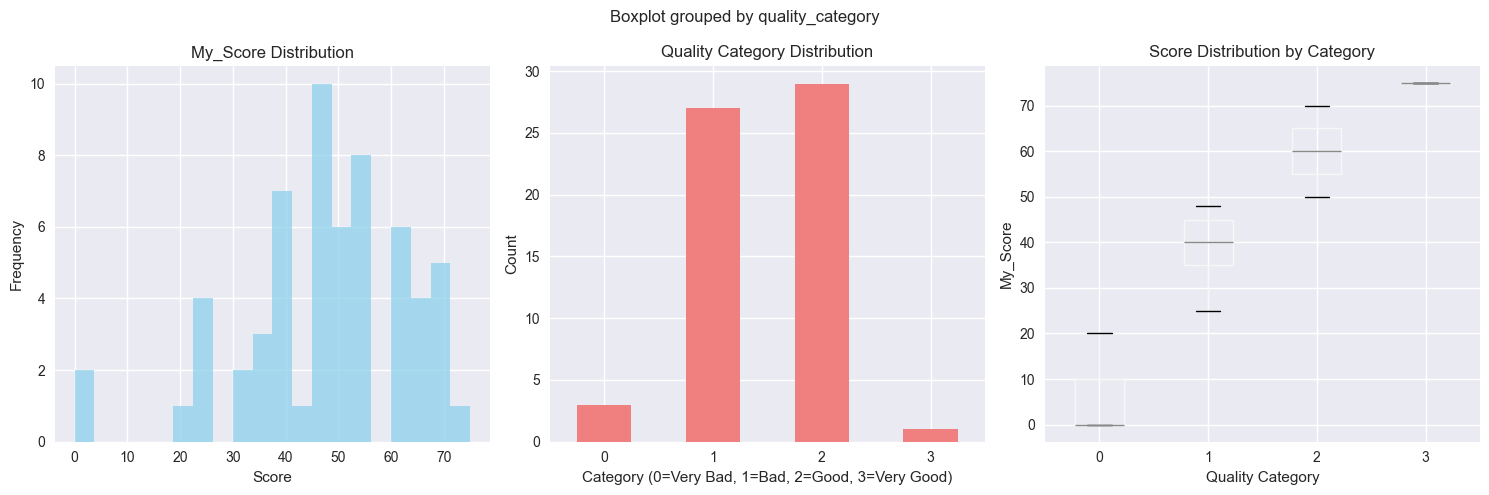

In [37]:
# Visualize quality score distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original my_score distribution
axes[0].hist(df_processed['my_score'], bins=20, alpha=0.7, color='skyblue')
axes[0].set_title('My_Score Distribution')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

# Quality category distribution
category_counts.plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Quality Category Distribution')
axes[1].set_xlabel('Category (0=Very Bad, 1=Bad, 2=Good, 3=Very Good)')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

# Box plot of scores by category
df_processed.boxplot(column='my_score', by='quality_category', ax=axes[2])
axes[2].set_title('Score Distribution by Category')
axes[2].set_xlabel('Quality Category')
axes[2].set_ylabel('My_Score')

plt.tight_layout()
plt.show()

Input feature availability:
baseline_env_EnvH: 60/60 (100.0%)
baseline_env_EnvT: 60/60 (100.0%)
before_turn_on_env_InH: 60/60 (100.0%)
before_turn_on_env_InT: 60/60 (100.0%)
before_turn_on_env_IrO: 60/60 (100.0%)


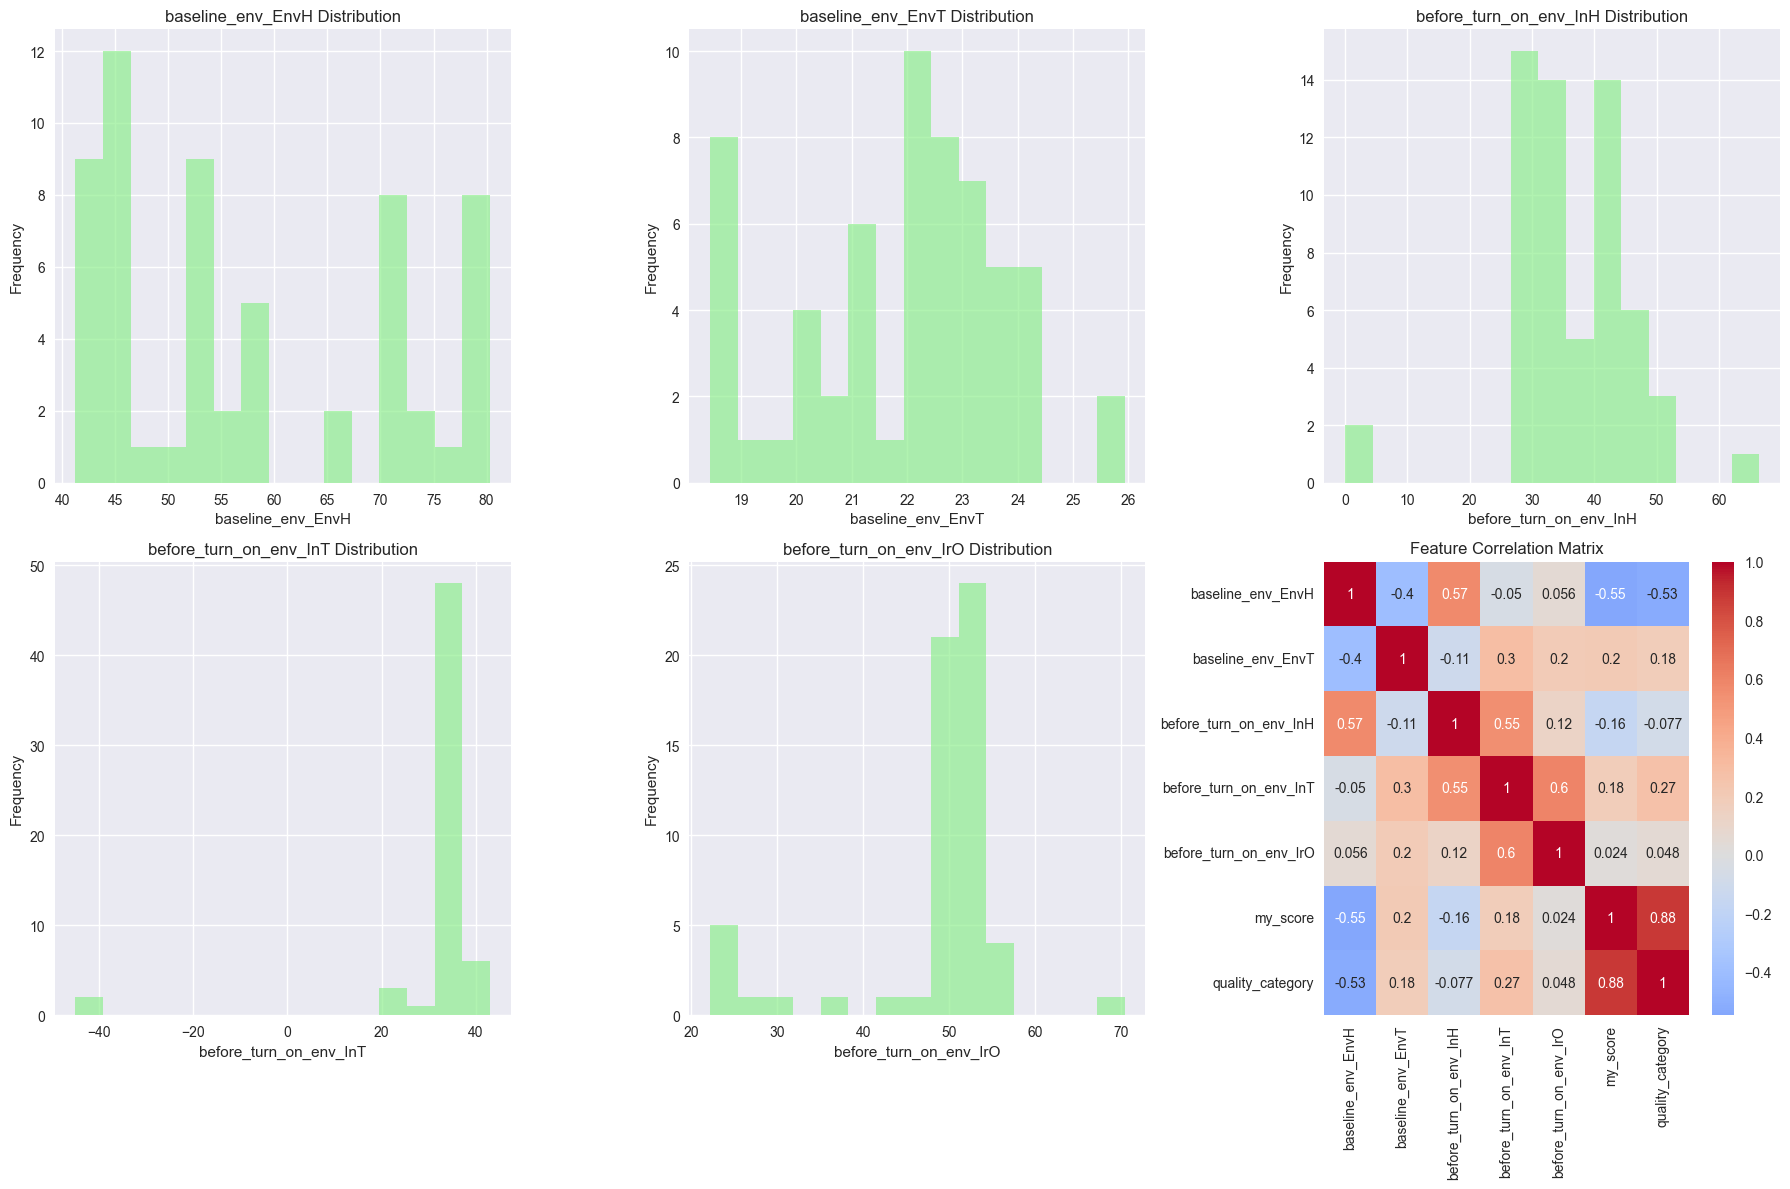

In [38]:
# Define our input features (environmental variables)
input_features = [
    'baseline_env_EnvH',
    'baseline_env_EnvT', 
    'before_turn_on_env_InH',
    'before_turn_on_env_InT',
    'before_turn_on_env_IrO'
]

# Check data availability for these features
print("Input feature availability:")
for feature in input_features:
    if feature in df_processed.columns:
        non_null = df_processed[feature].notna().sum()
        print(f"{feature}: {non_null}/{len(df_processed)} ({non_null/len(df_processed)*100:.1f}%)")
    else:
        print(f"{feature}: Column not found!")

# Visualize environmental variables
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(input_features):
    if feature in df_processed.columns:
        # Convert to numeric
        values = pd.to_numeric(df_processed[feature], errors='coerce')
        axes[i].hist(values.dropna(), bins=15, alpha=0.7, color='lightgreen')
        axes[i].set_title(f'{feature} Distribution')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

# Correlation heatmap
numeric_cols = input_features + ['my_score', 'quality_category']
correlation_data = df_processed[numeric_cols].copy()
for col in correlation_data.columns:
    correlation_data[col] = pd.to_numeric(correlation_data[col], errors='coerce')

correlation_matrix = correlation_data.corr()
axes[5].clear()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[5])
axes[5].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

## 4. Feature Selection and Engineering

In [39]:
# Prepare feature matrix and target variable (UPDATED FOR BINARY CLASSIFICATION)
# Use only complete cases for the input features
feature_data = df_processed[input_features + ['binary_category', 'start_temp', 'cook_temp']].copy()

# Convert all columns to numeric
for col in feature_data.columns:
    feature_data[col] = pd.to_numeric(feature_data[col], errors='coerce')

# Remove rows with any missing input features
complete_data = feature_data.dropna(subset=input_features + ['binary_category'])
print(f"Complete cases for modeling: {len(complete_data)}")

if len(complete_data) == 0:
    print("No complete cases found! Checking individual features...")
    for feature in input_features:
        available = df_processed[feature].notna().sum()
        print(f"{feature}: {available} non-null values")
else:
    # Separate features and targets (USING BINARY CLASSIFICATION)
    X = complete_data[input_features]
    y = complete_data['binary_category']  # Changed to binary_category
    
    # Store start_temp and cook_temp for optimization analysis later
    temps_data = complete_data[['start_temp', 'cook_temp', 'binary_category']].dropna()
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Target variable distribution (Binary):")
    target_counts = y.value_counts().sort_index()
    print(f"Not Good (0): {target_counts[0]} samples")
    print(f"Good (1): {target_counts[1]} samples")
    
    print(f"\nTemperature data available for {len(temps_data)} samples")
    print("\nFeature statistics:")
    print(X.describe())

Complete cases for modeling: 60
Feature matrix shape: (60, 5)
Target variable distribution (Binary):
Not Good (0): 20 samples
Good (1): 40 samples

Temperature data available for 60 samples

Feature statistics:
       baseline_env_EnvH  baseline_env_EnvT  before_turn_on_env_InH  \
count          60.000000          60.000000               60.000000   
mean           57.579833          21.887667               36.516833   
std            13.269276           1.879052               10.279658   
min            41.230000          18.440000                0.000000   
25%            45.552500          20.672500               30.562500   
50%            53.180000          22.220000               34.545000   
75%            70.000000          23.060000               43.832500   
max            80.320000          25.930000               66.470000   

       before_turn_on_env_InT  before_turn_on_env_IrO  
count               60.000000               60.000000  
mean                32.276167        

In [40]:
# Scale features for models that require it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=input_features, index=X.index)

print("Feature scaling completed")
print(f"Original feature ranges:")
for col in X.columns:
    print(f"{col}: {X[col].min():.2f} to {X[col].max():.2f}")

print(f"\nScaled feature ranges:")
for i, col in enumerate(input_features):
    print(f"{col}: {X_scaled_df.iloc[:, i].min():.2f} to {X_scaled_df.iloc[:, i].max():.2f}")

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

X_train_unscaled, X_test_unscaled = train_test_split(
    X, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"Test set class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Feature scaling completed
Original feature ranges:
baseline_env_EnvH: 41.23 to 80.32
baseline_env_EnvT: 18.44 to 25.93
before_turn_on_env_InH: 0.00 to 66.47
before_turn_on_env_InT: -45.00 to 43.00
before_turn_on_env_IrO: 22.19 to 70.41

Scaled feature ranges:
baseline_env_EnvH: -1.24 to 1.73
baseline_env_EnvT: -1.85 to 2.17
before_turn_on_env_InH: -3.58 to 2.94
before_turn_on_env_InT: -5.23 to 0.73
before_turn_on_env_IrO: -2.84 to 2.43

Train set: 48 samples
Test set: 12 samples
Train set class distribution:
binary_category
0    16
1    32
Name: count, dtype: int64
Test set class distribution:
binary_category
0    4
1    8
Name: count, dtype: int64


## 5. Model Training and Comparison

In [41]:
# Define multiple classification models for BINARY CLASSIFICATION
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=42, probability=True),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Models that need scaled data
scaled_models = ['Logistic Regression', 'SVM', 'Naive Bayes']

# Store results
cv_scores = {}
test_scores = {}
trained_models = {}

# Cross-validation setup
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training and evaluating BINARY CLASSIFICATION models...")
print(f"Target: Predict Good (≥45) vs Not Good (<45) cotton candy")
print("=" * 60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Choose appropriate data (scaled or unscaled)
    if name in scaled_models:
        X_train_model = X_train
        X_test_model = X_test
    else:
        X_train_model = X_train_unscaled
        X_test_model = X_test_unscaled
    
    # Cross-validation
    cv_score = cross_val_score(model, X_train_model, y_train, cv=cv_folds, scoring='accuracy')
    cv_scores[name] = cv_score
    
    # Train on full training set
    model.fit(X_train_model, y_train)
    trained_models[name] = model
    
    # Test set performance
    test_pred = model.predict(X_test_model)
    test_acc = accuracy_score(y_test, test_pred)
    test_scores[name] = test_acc
    
    print(f"CV Accuracy: {cv_score.mean():.3f} (+/- {cv_score.std() * 2:.3f})")
    print(f"Test Accuracy: {test_acc:.3f}")

print(f"\n" + "=" * 60)
print("SUMMARY OF BINARY CLASSIFICATION MODEL PERFORMANCE")
print("=" * 60)

Training and evaluating BINARY CLASSIFICATION models...
Target: Predict Good (≥45) vs Not Good (<45) cotton candy

Training Logistic Regression...
CV Accuracy: 0.584 (+/- 0.340)
Test Accuracy: 0.750

Training Decision Tree...
CV Accuracy: 0.544 (+/- 0.255)
Test Accuracy: 0.833

Training Naive Bayes...
CV Accuracy: 0.649 (+/- 0.362)
Test Accuracy: 0.583

Training SVM...
CV Accuracy: 0.644 (+/- 0.291)
Test Accuracy: 0.750

Training Random Forest...
CV Accuracy: 0.544 (+/- 0.428)
Test Accuracy: 0.667

SUMMARY OF BINARY CLASSIFICATION MODEL PERFORMANCE
CV Accuracy: 0.544 (+/- 0.428)
Test Accuracy: 0.667

SUMMARY OF BINARY CLASSIFICATION MODEL PERFORMANCE


## 6. Model Evaluation and Performance Metrics

Model Performance Comparison:
                 Model  CV_Mean  CV_Std  Test_Accuracy
1        Decision Tree    0.544   0.127          0.833
0  Logistic Regression    0.584   0.170          0.750
3                  SVM    0.644   0.146          0.750
4        Random Forest    0.544   0.214          0.667
2          Naive Bayes    0.649   0.181          0.583


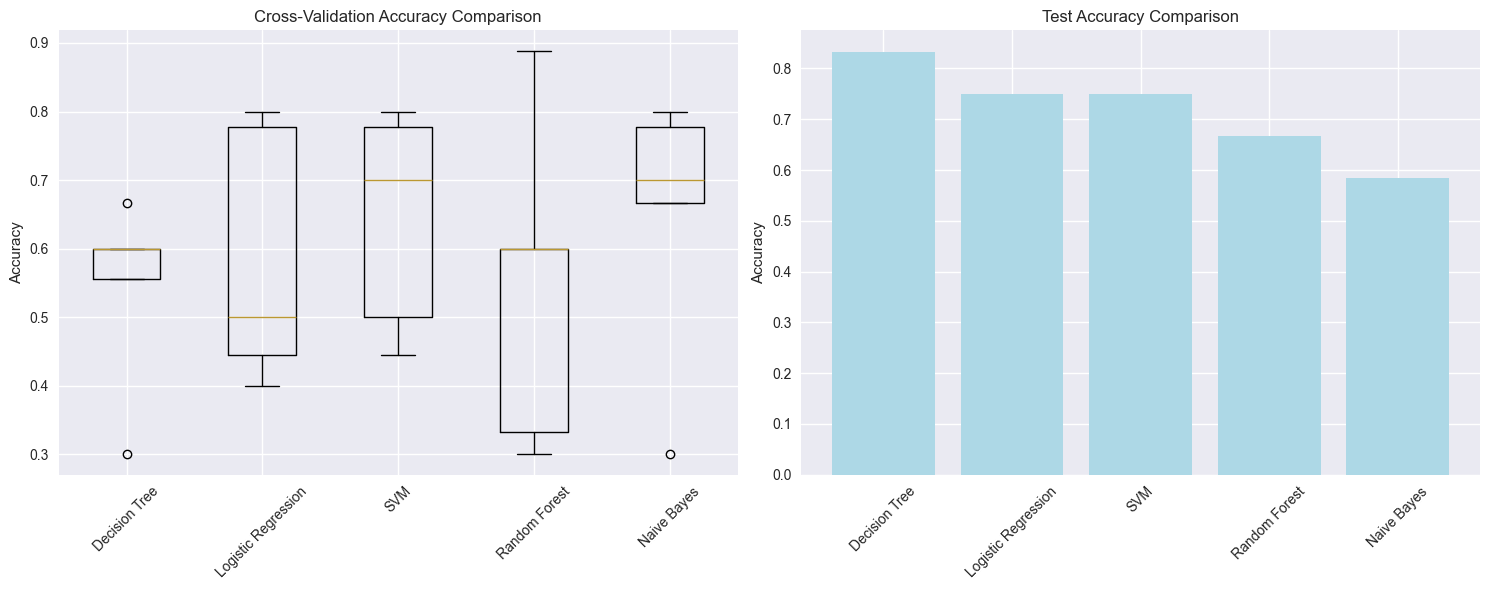


Best performing model: Decision Tree
Test Accuracy: 0.833


In [42]:
# Compare model performance
results_df = pd.DataFrame({
    'Model': list(cv_scores.keys()),
    'CV_Mean': [scores.mean() for scores in cv_scores.values()],
    'CV_Std': [scores.std() for scores in cv_scores.values()],
    'Test_Accuracy': list(test_scores.values())
})

results_df = results_df.sort_values('Test_Accuracy', ascending=False)
print("Model Performance Comparison:")
print(results_df.round(3))

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# CV scores comparison
cv_data = [cv_scores[model] for model in results_df['Model']]
axes[0].boxplot(cv_data, labels=results_df['Model'])
axes[0].set_title('Cross-Validation Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)

# Test accuracy comparison
axes[1].bar(results_df['Model'], results_df['Test_Accuracy'], color='lightblue')
axes[1].set_title('Test Accuracy Comparison')
axes[1].set_ylabel('Accuracy')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
print(f"\nBest performing model: {best_model_name}")
print(f"Test Accuracy: {results_df.iloc[0]['Test_Accuracy']:.3f}")


Detailed Classification Report for Decision Tree (BINARY):
                precision    recall  f1-score   support

Not Good (<45)       1.00      0.50      0.67         4
    Good (≥45)       0.80      1.00      0.89         8

      accuracy                           0.83        12
     macro avg       0.90      0.75      0.78        12
  weighted avg       0.87      0.83      0.81        12



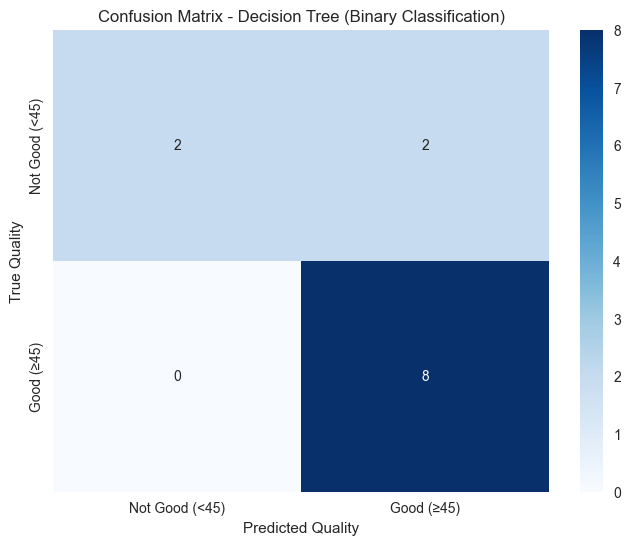


Per-class Metrics for Decision Tree (Binary Classification):
            Class  Precision  Recall  F1-Score  Support
0  Not Good (<45)        1.0     0.5     0.667        4
1      Good (≥45)        0.8     1.0     0.889        8

ROC-AUC Score: 0.781


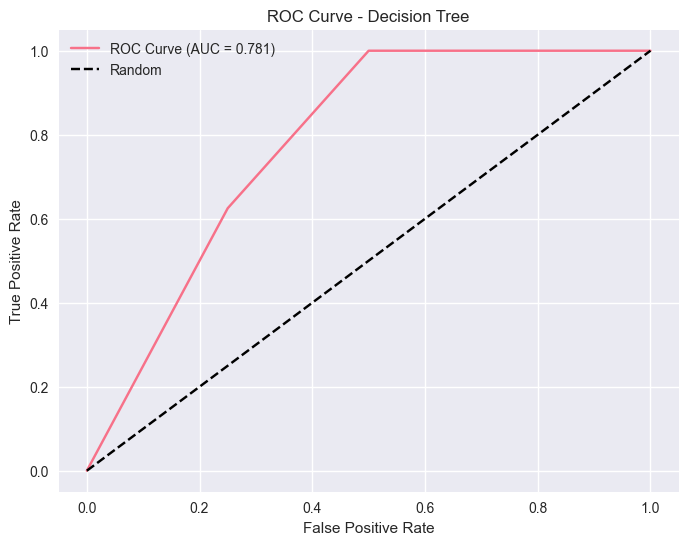

In [43]:
# Detailed evaluation for best BINARY CLASSIFICATION model
if best_model_name in scaled_models:
    X_test_best = X_test
else:
    X_test_best = X_test_unscaled

y_pred_best = best_model.predict(X_test_best)

# Classification report for binary classification
print(f"\nDetailed Classification Report for {best_model_name} (BINARY):")
print("=" * 70)
print(classification_report(y_test, y_pred_best, 
                          target_names=['Not Good (<45)', 'Good (≥45)']))

# Confusion Matrix for binary classification
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Good (<45)', 'Good (≥45)'],
            yticklabels=['Not Good (<45)', 'Good (≥45)'])
plt.title(f'Confusion Matrix - {best_model_name} (Binary Classification)')
plt.xlabel('Predicted Quality')
plt.ylabel('True Quality')
plt.show()

# Per-class metrics for binary classification
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_best)
metrics_df = pd.DataFrame({
    'Class': ['Not Good (<45)', 'Good (≥45)'],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})
print(f"\nPer-class Metrics for {best_model_name} (Binary Classification):")
print(metrics_df.round(3))

# Additional binary classification metrics
from sklearn.metrics import roc_auc_score, roc_curve
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test_best)[:, 1]
    auc_score = roc_auc_score(y_test, y_proba)
    print(f"\nROC-AUC Score: {auc_score:.3f}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.legend()
    plt.show()

## 7. Feature Importance Analysis

Feature Importance (Random Forest):
                  Feature  Importance
0       baseline_env_EnvH      0.2154
1       baseline_env_EnvT      0.2119
3  before_turn_on_env_InT      0.2098
2  before_turn_on_env_InH      0.1866
4  before_turn_on_env_IrO      0.1763


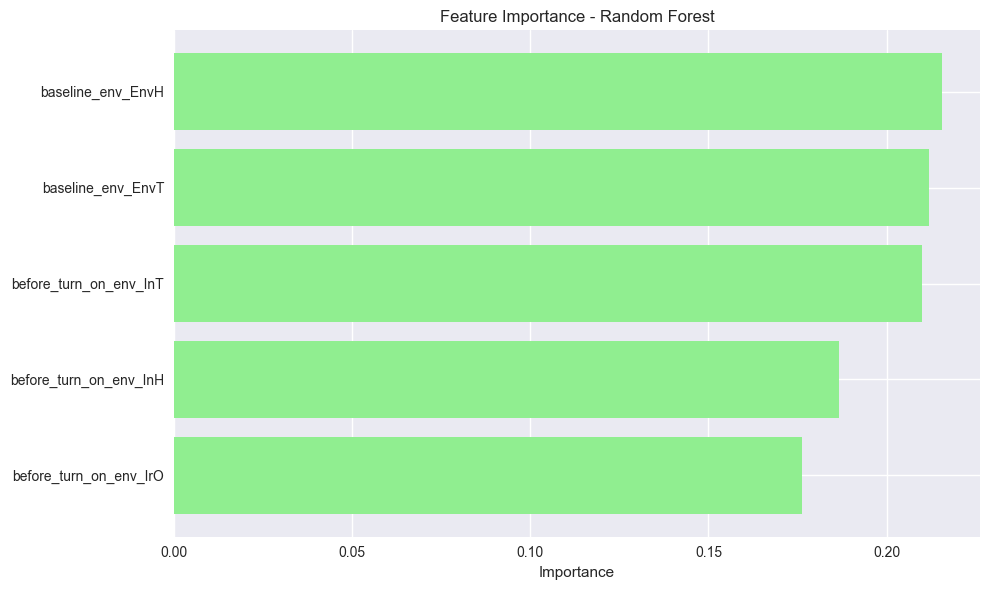


Feature Importance Comparison (RF vs DT):
                  Feature  RF_Importance  DT_Importance
0       baseline_env_EnvH         0.2154         0.2986
1       baseline_env_EnvT         0.2119         0.0000
3  before_turn_on_env_InT         0.2098         0.3250
2  before_turn_on_env_InH         0.1866         0.2561
4  before_turn_on_env_IrO         0.1763         0.1203


In [44]:
# Feature importance analysis
rf_model = trained_models['Random Forest']

# Get feature importances
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': input_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(importance_df.round(4))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Analyze feature importance for other tree-based models
if 'Decision Tree' in trained_models:
    dt_importance = trained_models['Decision Tree'].feature_importances_
    dt_importance_df = pd.DataFrame({
        'Feature': input_features,
        'RF_Importance': feature_importance,
        'DT_Importance': dt_importance
    }).sort_values('RF_Importance', ascending=False)
    
    print("\nFeature Importance Comparison (RF vs DT):")
    print(dt_importance_df.round(4))

## 8. Temperature Optimization Analysis

Temperature Optimization Analysis (BINARY CLASSIFICATION)
Temperature Statistics by Binary Quality Category:
                start_temp                           cook_temp               \
                      mean   std    min    max count      mean   std    min   
binary_category                                                               
0                    50.64  3.38  42.11  55.00    20     58.53  7.65  49.11   
1                    50.30  5.53  31.33  68.97    40     53.59  5.07  33.49   

                              
                   max count  
binary_category               
0                71.43    20  
1                71.61    40  


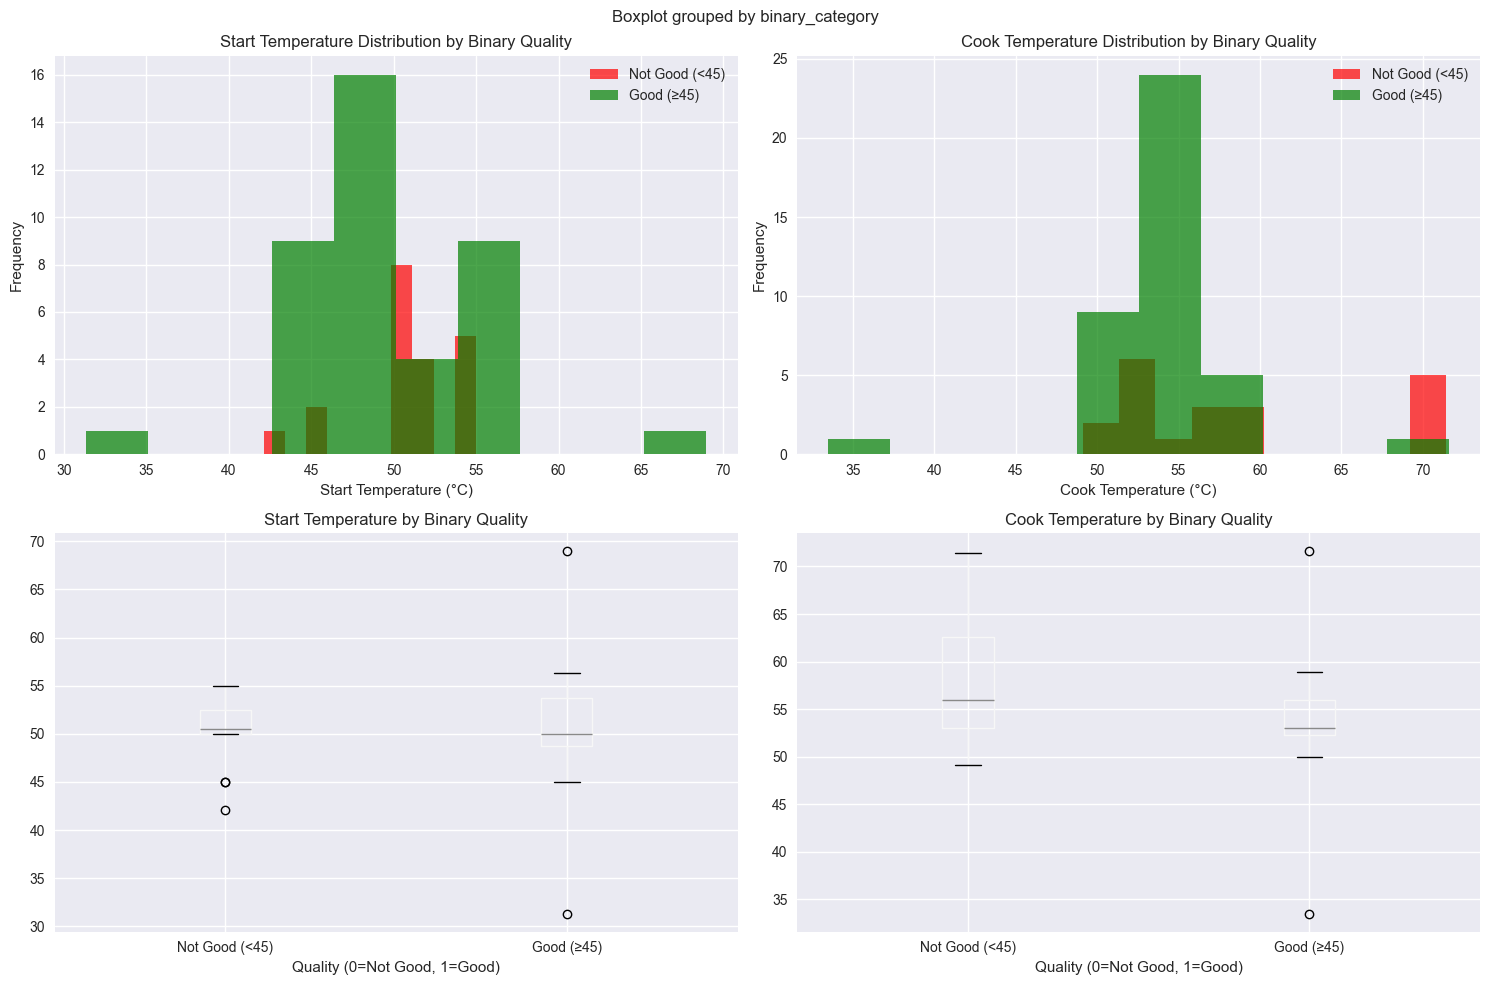

In [45]:
# Temperature optimization for BINARY CLASSIFICATION: Find optimal start_temp and cook_temp
print("Temperature Optimization Analysis (BINARY CLASSIFICATION)")
print("=" * 70)

# Analyze temperature patterns by binary quality category
if len(temps_data) > 0:
    temp_analysis = temps_data.groupby('binary_category').agg({
        'start_temp': ['mean', 'std', 'min', 'max', 'count'],
        'cook_temp': ['mean', 'std', 'min', 'max', 'count']
    }).round(2)
    
    print("Temperature Statistics by Binary Quality Category:")
    print(temp_analysis)
    
    # Visualize temperature distributions by binary category
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Start temperature by category
    for cat in sorted(temps_data['binary_category'].unique()):
        cat_data = temps_data[temps_data['binary_category'] == cat]
        label = 'Not Good (<45)' if cat == 0 else 'Good (≥45)'
        color = 'red' if cat == 0 else 'green'
        axes[0,0].hist(cat_data['start_temp'], alpha=0.7, label=label, bins=10, color=color)
    axes[0,0].set_title('Start Temperature Distribution by Binary Quality')
    axes[0,0].set_xlabel('Start Temperature (°C)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    
    # Cook temperature by category
    for cat in sorted(temps_data['binary_category'].unique()):
        cat_data = temps_data[temps_data['binary_category'] == cat]
        label = 'Not Good (<45)' if cat == 0 else 'Good (≥45)'
        color = 'red' if cat == 0 else 'green'
        axes[0,1].hist(cat_data['cook_temp'], alpha=0.7, label=label, bins=10, color=color)
    axes[0,1].set_title('Cook Temperature Distribution by Binary Quality')
    axes[0,1].set_xlabel('Cook Temperature (°C)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].legend()
    
    # Box plots
    temps_data.boxplot(column='start_temp', by='binary_category', ax=axes[1,0])
    axes[1,0].set_title('Start Temperature by Binary Quality')
    axes[1,0].set_xlabel('Quality (0=Not Good, 1=Good)')
    axes[1,0].set_xticklabels(['Not Good (<45)', 'Good (≥45)'])
    
    temps_data.boxplot(column='cook_temp', by='binary_category', ax=axes[1,1])
    axes[1,1].set_title('Cook Temperature by Binary Quality')
    axes[1,1].set_xlabel('Quality (0=Not Good, 1=Good)')
    axes[1,1].set_xticklabels(['Not Good (<45)', 'Good (≥45)'])
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No temperature data available for analysis")

In [46]:
# Optimal temperature recommendations for BINARY CLASSIFICATION
print("\n" + "=" * 70)
print("OPTIMAL TEMPERATURE RECOMMENDATIONS (BINARY CLASSIFICATION)")
print("=" * 70)

if len(temps_data) > 0:
    recommendations = {}
    
    for cat in sorted(temps_data['binary_category'].unique()):
        cat_data = temps_data[temps_data['binary_category'] == cat]
        
        if len(cat_data) > 0:
            start_temp_opt = cat_data['start_temp'].mean()
            cook_temp_opt = cat_data['cook_temp'].mean()
            
            # Get ranges (mean ± std)
            start_temp_std = cat_data['start_temp'].std()
            cook_temp_std = cat_data['cook_temp'].std()
            
            start_range = (start_temp_opt - start_temp_std, start_temp_opt + start_temp_std)
            cook_range = (cook_temp_opt - cook_temp_std, cook_temp_opt + cook_temp_std)
            
            quality_names = {0: 'Not Good (<45)', 1: 'Good (≥45)'}
            
            recommendations[cat] = {
                'start_temp_optimal': start_temp_opt,
                'cook_temp_optimal': cook_temp_opt,
                'start_temp_range': start_range,
                'cook_temp_range': cook_range,
                'sample_count': len(cat_data)
            }
            
            print(f"\n{quality_names[cat]} Cotton Candy:")
            print(f"  Optimal Start Temperature: {start_temp_opt:.1f}°C")
            print(f"  Recommended Range: {start_range[0]:.1f}°C - {start_range[1]:.1f}°C")
            print(f"  Optimal Cook Temperature: {cook_temp_opt:.1f}°C")
            print(f"  Recommended Range: {cook_range[0]:.1f}°C - {cook_range[1]:.1f}°C")
            print(f"  Based on {len(cat_data)} samples")
    
    # Summary table
    if recommendations:
        summary_df = pd.DataFrame({
            'Quality_Category': list(recommendations.keys()),
            'Quality_Name': ['Not Good (<45)' if i == 0 else 'Good (≥45)' for i in recommendations.keys()],
            'Optimal_Start_Temp': [rec['start_temp_optimal'] for rec in recommendations.values()],
            'Optimal_Cook_Temp': [rec['cook_temp_optimal'] for rec in recommendations.values()],
            'Sample_Count': [rec['sample_count'] for rec in recommendations.values()]
        })
        
        print(f"\n\nSUMMARY TABLE:")
        print(summary_df.round(1))
        
        # For achieving GOOD cotton candy (category 1, score ≥45)
        good_quality_data = temps_data[temps_data['binary_category'] == 1]
        if len(good_quality_data) > 0:
            print(f"\n" + "="*70)
            print("RECOMMENDATIONS FOR GOOD COTTON CANDY (Score ≥45)")
            print("="*70)
            print(f"Based on {len(good_quality_data)} good-quality samples:")
            print(f"Start Temperature: {good_quality_data['start_temp'].mean():.1f}°C ± {good_quality_data['start_temp'].std():.1f}")
            print(f"Cook Temperature: {good_quality_data['cook_temp'].mean():.1f}°C ± {good_quality_data['cook_temp'].std():.1f}")
            print(f"Range - Start: {good_quality_data['start_temp'].min():.1f}°C to {good_quality_data['start_temp'].max():.1f}°C")
            print(f"Range - Cook: {good_quality_data['cook_temp'].min():.1f}°C to {good_quality_data['cook_temp'].max():.1f}°C")
            
            # Temperature difference analysis
            temp_diff = good_quality_data['cook_temp'] - good_quality_data['start_temp']
            print(f"\nTemperature increase from start to cook:")
            print(f"Average increase: {temp_diff.mean():.1f}°C ± {temp_diff.std():.1f}")
            print(f"Range: {temp_diff.min():.1f}°C to {temp_diff.max():.1f}°C")

else:
    print("No temperature data available for recommendations")


OPTIMAL TEMPERATURE RECOMMENDATIONS (BINARY CLASSIFICATION)

Not Good (<45) Cotton Candy:
  Optimal Start Temperature: 50.6°C
  Recommended Range: 47.3°C - 54.0°C
  Optimal Cook Temperature: 58.5°C
  Recommended Range: 50.9°C - 66.2°C
  Based on 20 samples

Good (≥45) Cotton Candy:
  Optimal Start Temperature: 50.3°C
  Recommended Range: 44.8°C - 55.8°C
  Optimal Cook Temperature: 53.6°C
  Recommended Range: 48.5°C - 58.7°C
  Based on 40 samples


SUMMARY TABLE:
   Quality_Category    Quality_Name  Optimal_Start_Temp  Optimal_Cook_Temp  \
0                 0  Not Good (<45)                50.6               58.5   
1                 1      Good (≥45)                50.3               53.6   

   Sample_Count  
0            20  
1            40  

RECOMMENDATIONS FOR GOOD COTTON CANDY (Score ≥45)
Based on 40 good-quality samples:
Start Temperature: 50.3°C ± 5.5
Cook Temperature: 53.6°C ± 5.1
Range - Start: 31.3°C to 69.0°C
Range - Cook: 33.5°C to 71.6°C

Temperature increase from start

In [49]:
# Model prediction for temperature optimization
print(f"\n" + "="*60)
print("MODEL-BASED TEMPERATURE PREDICTION")
print("="*60)

# Use the best model to predict quality for different environmental conditions
print(f"Using {best_model_name} for prediction")

# Create a grid of environmental conditions for prediction
if len(complete_data) > 0:
    # Get environmental variable ranges from the data
    env_ranges = {}
    for feature in input_features:
        values = complete_data[feature].dropna()
        env_ranges[feature] = {
            'min': values.min(),
            'max': values.max(),
            'mean': values.mean(),
            'std': values.std()
        }
    
    print(f"\nEnvironmental Variable Ranges in Dataset:")
    for feature, ranges in env_ranges.items():
        print(f"{feature}: {ranges['min']:.1f} to {ranges['max']:.1f} (mean: {ranges['mean']:.1f})")
    
    # Example prediction for typical conditions
    typical_conditions = np.array([[
        env_ranges[feature]['mean'] for feature in input_features
    ]])
    
    if best_model_name in scaled_models:
        typical_conditions_scaled = scaler.transform(typical_conditions)
        predicted_quality = best_model.predict(typical_conditions_scaled)[0]
    else:
        predicted_quality = best_model.predict(typical_conditions)[0]
    
    quality_names = {0: 'Very Bad', 1: 'Bad', 2: 'Good', 3: 'Very Good'}
    
    print(f"\nPrediction for typical environmental conditions:")
    print(f"Input conditions: {dict(zip(input_features, typical_conditions[0]))}")
    print(f"Predicted Quality: Category {predicted_quality} ({quality_names[predicted_quality]})")
    
    # If we have temperature recommendations for this quality category
    if predicted_quality in recommendations:
        rec = recommendations[predicted_quality]
        print(f"\nRecommended temperature settings:")
        print(f"Start Temperature: {rec['start_temp_optimal']:.1f}°C")
        print(f"Cook Temperature: {rec['cook_temp_optimal']:.1f}°C")

print(f"\n" + "="*60)
print("CONCLUSION")
print("="*60)
print("This model can be used to:")
print("1. Predict cotton candy quality based on environmental conditions")
print("2. Recommend optimal start_temp and cook_temp settings")
print("3. Adjust process parameters to achieve desired quality levels")
print("\nTo use this model in production:")
print("- Input current environmental conditions")
print("- Get quality prediction") 
print("- Apply recommended temperature settings")
print("- Monitor results and retrain model with new data")


MODEL-BASED TEMPERATURE PREDICTION
Using Decision Tree for prediction

Environmental Variable Ranges in Dataset:
baseline_env_EnvH: 41.2 to 80.3 (mean: 57.6)
baseline_env_EnvT: 18.4 to 25.9 (mean: 21.9)
before_turn_on_env_InH: 0.0 to 66.5 (mean: 36.5)
before_turn_on_env_InT: -45.0 to 43.0 (mean: 32.3)
before_turn_on_env_IrO: 22.2 to 70.4 (mean: 48.2)

Prediction for typical environmental conditions:
Input conditions: {'baseline_env_EnvH': np.float64(57.57983333333333), 'baseline_env_EnvT': np.float64(21.887666666666668), 'before_turn_on_env_InH': np.float64(36.51683333333333), 'before_turn_on_env_InT': np.float64(32.27616666666667), 'before_turn_on_env_IrO': np.float64(48.193333333333335)}
Predicted Quality: Category 1 (Bad)

Recommended temperature settings:
Start Temperature: 50.3°C
Cook Temperature: 53.6°C

CONCLUSION
This model can be used to:
1. Predict cotton candy quality based on environmental conditions
2. Recommend optimal start_temp and cook_temp settings
3. Adjust process 

## 9. Temperature Correlation Analysis for Good Results (>50)

In [ ]:
def analyze_temperature_correlations(df, quality_threshold=50):
    """
    Analyzes correlations between start_temp, cook_temp, and cooled_temp for high-quality cotton candy.
    
    Parameters:
    df: DataFrame with temperature columns and my_score
    quality_threshold: Minimum score to consider as "good" (default: 50)
    
    Returns:
    dict: Contains correlation matrix, statistics, and optimization insights
    """
    
    # Filter data for good results (>= threshold)
    good_results = df[df['my_score'] >= quality_threshold].copy()
    
    # Temperature columns of interest
    temp_columns = ['start_temp', 'cook_temp', 'cooled_temp']
    
    # Convert to numeric and handle missing values
    for col in temp_columns:
        if col in good_results.columns:
            good_results[col] = pd.to_numeric(good_results[col], errors='coerce')
    
    # Remove rows with missing temperature data
    temp_data = good_results[temp_columns + ['my_score']].dropna()
    
    print(f"Temperature Correlation Analysis for Cotton Candy Quality >= {quality_threshold}")
    print("=" * 80)
    print(f"Total samples with quality >= {quality_threshold}: {len(good_results)}")
    print(f"Samples with complete temperature data: {len(temp_data)}")
    
    if len(temp_data) < 3:
        print("Insufficient data for correlation analysis!")
        return None
    
    # Calculate correlation matrix
    correlation_matrix = temp_data[temp_columns].corr()
    
    print(f"\nCorrelation Matrix for Temperature Variables:")
    print("-" * 50)
    print(correlation_matrix.round(3))
    
    # Calculate temperature differences and ratios
    temp_data['cook_start_diff'] = temp_data['cook_temp'] - temp_data['start_temp']
    temp_data['cook_cool_diff'] = temp_data['cook_temp'] - temp_data['cooled_temp']
    temp_data['start_cool_diff'] = temp_data['start_temp'] - temp_data['cooled_temp']
    
    # Temperature ratios
    temp_data['cook_start_ratio'] = temp_data['cook_temp'] / temp_data['start_temp']
    temp_data['cool_start_ratio'] = temp_data['cooled_temp'] / temp_data['start_temp']
    temp_data['cool_cook_ratio'] = temp_data['cooled_temp'] / temp_data['cook_temp']
    
    # Statistics for each temperature variable
    print(f"\nTemperature Statistics for Quality >= {quality_threshold}:")
    print("-" * 50)
    temp_stats = temp_data[temp_columns].describe()
    print(temp_stats.round(1))
    
    # Temperature differences analysis
    print(f"\nTemperature Differences Analysis:")
    print("-" * 50)
    diff_columns = ['cook_start_diff', 'cook_cool_diff', 'start_cool_diff']
    diff_stats = temp_data[diff_columns].describe()
    print(diff_stats.round(1))
    
    # Temperature ratios analysis
    print(f"\nTemperature Ratios Analysis:")
    print("-" * 50)
    ratio_columns = ['cook_start_ratio', 'cool_start_ratio', 'cool_cook_ratio']
    ratio_stats = temp_data[ratio_columns].describe()
    print(ratio_stats.round(3))
    
    # Correlation with quality score
    print(f"\nCorrelation with Quality Score:")
    print("-" * 50)
    all_correlations = temp_data[temp_columns + diff_columns + ratio_columns + ['my_score']].corr()['my_score'].sort_values(ascending=False)
    print(all_correlations.drop('my_score').round(3))
    
    # Find optimal temperature relationships
    print(f"\nOptimal Temperature Relationships for Quality >= {quality_threshold}:")
    print("-" * 50)
    
    # Group by quality ranges for more detailed analysis
    temp_data['quality_range'] = pd.cut(temp_data['my_score'], 
                                       bins=[quality_threshold-1, 60, 70, 100], 
                                       labels=['Good (50-60)', 'Very Good (60-70)', 'Excellent (70+)'])
    
    for quality_range in temp_data['quality_range'].dropna().unique():
        range_data = temp_data[temp_data['quality_range'] == quality_range]
        print(f"\n{quality_range} (n={len(range_data)}):")
        print(f"  Start Temp: {range_data['start_temp'].mean():.1f}°C ± {range_data['start_temp'].std():.1f}")
        print(f"  Cook Temp:  {range_data['cook_temp'].mean():.1f}°C ± {range_data['cook_temp'].std():.1f}")
        print(f"  Cool Temp:  {range_data['cooled_temp'].mean():.1f}°C ± {range_data['cooled_temp'].std():.1f}")
        print(f"  Cook-Start Diff: {range_data['cook_start_diff'].mean():.1f}°C ± {range_data['cook_start_diff'].std():.1f}")
        print(f"  Cook-Cool Diff:  {range_data['cook_cool_diff'].mean():.1f}°C ± {range_data['cook_cool_diff'].std():.1f}")
    
    return {
        'correlation_matrix': correlation_matrix,
        'temperature_data': temp_data,
        'temp_stats': temp_stats,
        'correlations_with_quality': all_correlations.drop('my_score'),
        'sample_count': len(temp_data)
    }

# Run the temperature correlation analysis
print("Running temperature correlation analysis for cotton candy quality >= 50...")
temp_analysis_results = analyze_temperature_correlations(df_processed, quality_threshold=50)

In [ ]:
# Visualize temperature correlations and patterns for good results
if temp_analysis_results is not None and len(temp_analysis_results['temperature_data']) > 0:
    
    temp_data = temp_analysis_results['temperature_data']
    correlation_matrix = temp_analysis_results['correlation_matrix']
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Correlation heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, ax=axes[0,0], cbar_kws={'shrink': 0.8})
    axes[0,0].set_title('Temperature Correlations\n(Quality ≥50)')
    
    # 2. Temperature scatter plots
    axes[0,1].scatter(temp_data['start_temp'], temp_data['cook_temp'], 
                     c=temp_data['my_score'], cmap='viridis', alpha=0.7)
    axes[0,1].set_xlabel('Start Temperature (°C)')
    axes[0,1].set_ylabel('Cook Temperature (°C)')
    axes[0,1].set_title('Start vs Cook Temperature\n(Color = Quality Score)')
    
    # Add trend line
    z = np.polyfit(temp_data['start_temp'], temp_data['cook_temp'], 1)
    p = np.poly1d(z)
    axes[0,1].plot(temp_data['start_temp'].sort_values(), 
                   p(temp_data['start_temp'].sort_values()), 
                   "r--", alpha=0.8, linewidth=2)
    
    # 3. Cook vs Cool temperature
    axes[0,2].scatter(temp_data['cook_temp'], temp_data['cooled_temp'], 
                     c=temp_data['my_score'], cmap='viridis', alpha=0.7)
    axes[0,2].set_xlabel('Cook Temperature (°C)')
    axes[0,2].set_ylabel('Cooled Temperature (°C)')
    axes[0,2].set_title('Cook vs Cooled Temperature\n(Color = Quality Score)')
    
    # Add trend line
    z2 = np.polyfit(temp_data['cook_temp'], temp_data['cooled_temp'], 1)
    p2 = np.poly1d(z2)
    axes[0,2].plot(temp_data['cook_temp'].sort_values(), 
                   p2(temp_data['cook_temp'].sort_values()), 
                   "r--", alpha=0.8, linewidth=2)
    
    # 4. Temperature differences histogram
    temp_diffs = ['cook_start_diff', 'cook_cool_diff', 'start_cool_diff']
    colors = ['red', 'blue', 'green']
    labels = ['Cook-Start', 'Cook-Cool', 'Start-Cool']
    
    for i, (diff_col, color, label) in enumerate(zip(temp_diffs, colors, labels)):
        axes[1,0].hist(temp_data[diff_col], alpha=0.6, color=color, label=label, bins=10)
    
    axes[1,0].set_xlabel('Temperature Difference (°C)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Temperature Differences Distribution\n(Quality ≥50)')
    axes[1,0].legend()
    
    # 5. 3D scatter plot (Start, Cook, Cool)
    from mpl_toolkits.mplot3d import Axes3D
    axes[1,1].remove()
    ax_3d = fig.add_subplot(2, 3, 5, projection='3d')
    
    scatter = ax_3d.scatter(temp_data['start_temp'], temp_data['cook_temp'], 
                           temp_data['cooled_temp'], c=temp_data['my_score'], 
                           cmap='viridis', alpha=0.7, s=50)
    ax_3d.set_xlabel('Start Temp (°C)')
    ax_3d.set_ylabel('Cook Temp (°C)')
    ax_3d.set_zlabel('Cool Temp (°C)')
    ax_3d.set_title('3D Temperature Relationship\n(Color = Quality)')
    
    # Add colorbar for 3D plot
    cbar = plt.colorbar(scatter, ax=ax_3d, shrink=0.8)
    cbar.set_label('Quality Score')
    
    # 6. Temperature progression pattern
    # Show average temperature progression pattern
    avg_temps = temp_data[['start_temp', 'cook_temp', 'cooled_temp']].mean()
    std_temps = temp_data[['start_temp', 'cook_temp', 'cooled_temp']].std()
    
    temp_stages = ['Start', 'Cook', 'Cool']
    axes[1,2].errorbar(temp_stages, avg_temps.values, yerr=std_temps.values, 
                       marker='o', markersize=8, linewidth=2, capsize=5)
    axes[1,2].set_ylabel('Temperature (°C)')
    axes[1,2].set_title('Average Temperature Progression\n(Quality ≥50)')
    axes[1,2].grid(True, alpha=0.3)
    
    # Add individual sample lines (transparent)
    for idx, row in temp_data.head(10).iterrows():  # Show only first 10 for clarity
        temps = [row['start_temp'], row['cook_temp'], row['cooled_temp']]
        axes[1,2].plot(temp_stages, temps, 'gray', alpha=0.2, linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation insights
    print(f"\n" + "="*80)
    print("TEMPERATURE CORRELATION INSIGHTS")
    print("="*80)
    
    # Extract key correlations
    corr_start_cook = correlation_matrix.loc['start_temp', 'cook_temp']
    corr_cook_cool = correlation_matrix.loc['cook_temp', 'cooled_temp']
    corr_start_cool = correlation_matrix.loc['start_temp', 'cooled_temp']
    
    print(f"Key Temperature Correlations for Quality ≥50:")
    print(f"• Start ↔ Cook Temperature: {corr_start_cook:.3f}")
    print(f"• Cook ↔ Cool Temperature: {corr_cook_cool:.3f}")
    print(f"• Start ↔ Cool Temperature: {corr_start_cool:.3f}")
    
    # Interpretation
    print(f"\nInterpretation:")
    if abs(corr_start_cook) > 0.7:
        print(f"• STRONG relationship between start and cook temperatures")
    elif abs(corr_start_cook) > 0.3:
        print(f"• MODERATE relationship between start and cook temperatures")
    else:
        print(f"• WEAK relationship between start and cook temperatures")
        
    if abs(corr_cook_cool) > 0.7:
        print(f"• STRONG relationship between cook and cool temperatures")
    elif abs(corr_cook_cool) > 0.3:
        print(f"• MODERATE relationship between cook and cool temperatures")
    else:
        print(f"• WEAK relationship between cook and cool temperatures")
    
    # Temperature progression analysis
    avg_cook_start_diff = temp_data['cook_start_diff'].mean()
    avg_cook_cool_diff = temp_data['cook_cool_diff'].mean()
    
    print(f"\nTemperature Progression Pattern:")
    print(f"• Average temperature increase (Start → Cook): {avg_cook_start_diff:.1f}°C")
    print(f"• Average temperature decrease (Cook → Cool): {avg_cook_cool_diff:.1f}°C")
    
    # Find optimal temperature ratios
    optimal_cook_start_ratio = temp_data['cook_start_ratio'].mean()
    optimal_cool_cook_ratio = temp_data['cool_cook_ratio'].mean()
    
    print(f"\nOptimal Temperature Ratios for Quality ≥50:")
    print(f"• Cook/Start Ratio: {optimal_cook_start_ratio:.2f} (Cook temp should be {optimal_cook_start_ratio:.1f}x start temp)")
    print(f"• Cool/Cook Ratio: {optimal_cool_cook_ratio:.2f} (Cool temp should be {optimal_cool_cook_ratio:.1f}x cook temp)")

else:
    print("No sufficient temperature data available for visualization")

In [ ]:
# Create a predictive function based on temperature correlations
def predict_optimal_temperatures(start_temp, target_quality=60):
    """
    Predicts optimal cook and cool temperatures based on start temperature
    and observed correlations from high-quality samples.
    
    Parameters:
    start_temp: Starting temperature in °C
    target_quality: Target quality score (default: 60)
    
    Returns:
    dict: Predicted cook_temp and cooled_temp
    """
    
    if temp_analysis_results is None:
        print("Temperature analysis not available!")
        return None
    
    temp_data = temp_analysis_results['temperature_data']
    
    # Calculate optimal ratios based on high-quality samples (≥60)
    high_quality_data = temp_data[temp_data['my_score'] >= target_quality]
    
    if len(high_quality_data) > 0:
        # Use high-quality samples
        analysis_data = high_quality_data
        print(f"Using {len(analysis_data)} samples with quality ≥{target_quality}")
    else:
        # Fall back to all good samples (≥50)
        analysis_data = temp_data
        print(f"Using {len(analysis_data)} samples with quality ≥50 (no samples ≥{target_quality})")
    
    # Calculate average ratios and differences from the analysis data
    avg_cook_start_ratio = analysis_data['cook_start_ratio'].mean()
    avg_cool_cook_ratio = analysis_data['cool_cook_ratio'].mean()
    
    avg_cook_start_diff = analysis_data['cook_start_diff'].mean()
    avg_cook_cool_diff = analysis_data['cook_cool_diff'].mean()
    
    # Predict temperatures using both ratio and difference methods
    # Method 1: Using ratios
    predicted_cook_temp_ratio = start_temp * avg_cook_start_ratio
    predicted_cool_temp_ratio = predicted_cook_temp_ratio * avg_cool_cook_ratio
    
    # Method 2: Using differences
    predicted_cook_temp_diff = start_temp + avg_cook_start_diff
    predicted_cool_temp_diff = predicted_cook_temp_diff - avg_cook_cool_diff
    
    # Average both methods for final prediction
    predicted_cook_temp = (predicted_cook_temp_ratio + predicted_cook_temp_diff) / 2
    predicted_cool_temp = (predicted_cool_temp_ratio + predicted_cool_temp_diff) / 2
    
    # Calculate confidence intervals based on standard deviations
    cook_temp_std = analysis_data['cook_temp'].std()
    cool_temp_std = analysis_data['cooled_temp'].std()
    
    return {
        'start_temp': start_temp,
        'predicted_cook_temp': predicted_cook_temp,
        'predicted_cool_temp': predicted_cool_temp,
        'cook_temp_range': (predicted_cook_temp - cook_temp_std, predicted_cook_temp + cook_temp_std),
        'cool_temp_range': (predicted_cool_temp - cool_temp_std, predicted_cool_temp + cool_temp_std),
        'based_on_samples': len(analysis_data),
        'target_quality': target_quality,
        'method_details': {
            'avg_cook_start_ratio': avg_cook_start_ratio,
            'avg_cool_cook_ratio': avg_cool_cook_ratio,
            'avg_cook_start_diff': avg_cook_start_diff,
            'avg_cook_cool_diff': avg_cook_cool_diff
        }
    }

# Test the prediction function with different start temperatures
print(f"\n" + "="*80)
print("TEMPERATURE PREDICTION FUNCTION")
print("="*80)

test_start_temps = [30, 40, 50, 60, 70]

for start_temp in test_start_temps:
    prediction = predict_optimal_temperatures(start_temp, target_quality=60)
    
    if prediction:
        print(f"\nFor Start Temperature = {start_temp}°C:")
        print(f"  Predicted Cook Temperature: {prediction['predicted_cook_temp']:.1f}°C")
        print(f"    Range: {prediction['cook_temp_range'][0]:.1f}°C - {prediction['cook_temp_range'][1]:.1f}°C")
        print(f"  Predicted Cool Temperature: {prediction['predicted_cool_temp']:.1f}°C")
        print(f"    Range: {prediction['cool_temp_range'][0]:.1f}°C - {prediction['cool_temp_range'][1]:.1f}°C")
        print(f"  Based on {prediction['based_on_samples']} high-quality samples")

In [ ]:
# Summary function for temperature correlation insights
def get_temperature_correlation_summary():
    """
    Provides a comprehensive summary of temperature correlations for high-quality cotton candy.
    """
    
    if temp_analysis_results is None:
        return "Temperature analysis not available. Please run the analysis first."
    
    temp_data = temp_analysis_results['temperature_data']
    correlation_matrix = temp_analysis_results['correlation_matrix']
    
    summary = []
    summary.append("=" * 80)
    summary.append("COTTON CANDY TEMPERATURE CORRELATION SUMMARY")
    summary.append("=" * 80)
    
    summary.append(f"\nDataset Overview:")
    summary.append(f"• Total samples with quality ≥50: {len(temp_data)}")
    summary.append(f"• Quality score range: {temp_data['my_score'].min():.1f} - {temp_data['my_score'].max():.1f}")
    
    # Key correlations
    summary.append(f"\nKey Temperature Correlations:")
    summary.append(f"• Start ↔ Cook: {correlation_matrix.loc['start_temp', 'cook_temp']:.3f}")
    summary.append(f"• Cook ↔ Cool: {correlation_matrix.loc['cook_temp', 'cooled_temp']:.3f}")
    summary.append(f"• Start ↔ Cool: {correlation_matrix.loc['start_temp', 'cooled_temp']:.3f}")
    
    # Temperature patterns
    summary.append(f"\nOptimal Temperature Patterns (Quality ≥50):")
    summary.append(f"• Start Temperature: {temp_data['start_temp'].mean():.1f}°C ± {temp_data['start_temp'].std():.1f}")
    summary.append(f"• Cook Temperature: {temp_data['cook_temp'].mean():.1f}°C ± {temp_data['cook_temp'].std():.1f}")
    summary.append(f"• Cool Temperature: {temp_data['cooled_temp'].mean():.1f}°C ± {temp_data['cooled_temp'].std():.1f}")
    
    # Temperature relationships
    summary.append(f"\nTemperature Relationships:")
    summary.append(f"• Cook temp is {temp_data['cook_start_ratio'].mean():.2f}x start temp on average")
    summary.append(f"• Cool temp is {temp_data['cool_cook_ratio'].mean():.2f}x cook temp on average")
    summary.append(f"• Average temperature increase (Start→Cook): {temp_data['cook_start_diff'].mean():.1f}°C")
    summary.append(f"• Average temperature decrease (Cook→Cool): {temp_data['cook_cool_diff'].mean():.1f}°C")
    
    # Strongest predictors
    correlations_with_quality = temp_analysis_results['correlations_with_quality']
    strongest_predictor = correlations_with_quality.abs().idxmax()
    strongest_correlation = correlations_with_quality[strongest_predictor]
    
    summary.append(f"\nStrongest Quality Predictor:")
    summary.append(f"• {strongest_predictor}: {strongest_correlation:.3f}")
    
    # Recommendations
    summary.append(f"\nRecommendations for High-Quality Cotton Candy:")
    
    # Find the best performing samples
    top_samples = temp_data[temp_data['my_score'] >= temp_data['my_score'].quantile(0.8)]
    if len(top_samples) > 0:
        summary.append(f"• Use start temperature around: {top_samples['start_temp'].mean():.1f}°C")
        summary.append(f"• Target cook temperature: {top_samples['cook_temp'].mean():.1f}°C")
        summary.append(f"• Expect cool temperature: {top_samples['cooled_temp'].mean():.1f}°C")
        summary.append(f"• Maintain temperature increase of: {top_samples['cook_start_diff'].mean():.1f}°C (Start→Cook)")
        summary.append(f"• Allow temperature decrease of: {top_samples['cook_cool_diff'].mean():.1f}°C (Cook→Cool)")
    
    summary.append("=" * 80)
    
    return "\n".join(summary)

# Display the comprehensive summary
print(get_temperature_correlation_summary())